In [2]:
### Libraries
using LinearAlgebra
using DelimitedFiles
using DifferentialEquations
using Tullio
⊗(A,B) = kron(A,B)

⊗ (generic function with 1 method)

### Initial parameters

In [3]:
### Constants
MBOHR = 5.788381e-5         ### Bohrs magneton
KB = 8.6173324e-5           ### Bolzmann factor
GAMMA_R = 1.760859644e-4    ### Gyromagnetic ratio ##1 for units of G_r=1
hbar = 1.0#0.658211928e0        ### Planck constant (eV*fs) 
k_Boltzman = 0.00008617343 ;#(eV/K) # 1.3806504d-23 (J/K)
### Parameters and initiallizations
ny = 1
nx = 2
ns = nx*ny
nσ = 2
nk = 400
nα = 2
t = 1
#tc = 1
γ = 1
γso = 0.0
γc = 0.0
ϵ0 = 0.0#2γ
j_sd = 0.0#0.1
Δ_α = [0.,0.]
### Dimensions of the problem
dim_s = ns*nσ#(nx*ns,nx*ns)
dim_e = nk*nσ
dim_α = nα
dims_Gleαs_kαi=(dim_e,dim_α,dim_s)
dims_Gls_ij = (dim_s,dim_s)
size_Gleαs_kαi = prod(dims_Gleαs_kαi) 
size_Gls_ij = prod(dims_Gls_ij)
### Pauli matrices
σ_0 = Matrix{ComplexF64}([1. 0. ; 0 1])
σ_x =  Matrix{ComplexF64}([0 1; 1 0])
σ_y =  Matrix{ComplexF64}([0 -1im ; 1im 0 ])
σ_z = Matrix{ComplexF64}([1 0. ; 0. -1])

I_a1b1 = Matrix{ComplexF64}(I, ns, ns)           # Identity on lattice space
I_ab = Matrix{ComplexF64}(I, nσ*ns, nσ*ns)        # Identity on lattice ⊗ spin
# --- Pauli matrices extended to the full Hilbert space ---
σ_x1ab = kron(I_a1b1, σ_x)
σ_x2ab = kron(I_a1b1, σ_y)
σ_x3ab = kron(I_a1b1, σ_z)
# --- Pauli matrices as a 3D array σ_abx[μ, i, j] ---
σ_ijx = cat(σ_x1ab, σ_x2ab, σ_x3ab; dims=3)
### Hamiltonians
hs_ij = zeros(ComplexF64, (dim_s,dim_s) )
heα_kα = zeros(ComplexF64, (dim_e,dim_α ))
heαs_kαi = zeros(ComplexF64, (dim_e,dim_α,dim_s) )
hseα_ikα = zeros(ComplexF64, (dim_s,dim_e,dim_α) )
### Green functions
gl_kα = zeros(ComplexF64, (dim_e,dim_α) )
### Dynamical variables
Gleαs_kαi = zeros(ComplexF64, dims_Gleαs_kαi  )
Gls_ij = zeros(ComplexF64, dims_Gls_ij );
### Observables

In [4]:
#σ_ijx[:,:,3]

In [5]:
#### Initiallizing the dynamical variables 
# σ_ijx 
# σ_x3ab
#LinRange(-pi,pi,nk)
#heα_kα[2:2:end,1]

In [6]:
#### Create electronic Hamiltonian 
function block_h(ny,γ,γso)
    #γ::Float64,γso::ComplexF64,Bz::Float64,ny::Int)
    "Creates the building blocks for a general nx x ny square lattice
    
    Returns:
       H0 :: intra-cell (y direction) Hamiltonian block of size (ny*nσ)×(ny*nσ)
       T  :: inter-cell (x direction) hopping block of same size"
    dim = ny*nσ # We include the spin degree of freedom 
    ######
    H0 = zeros(ComplexF64,dim,dim)
    T  = zeros(ComplexF64,dim,dim)
    One_y = Diagonal(ones(ny))
    ######
    Ty = diagm(-1 =>  ones(ny-1))
    T0 = Ty⊗(-γ*σ_0 - 1im*γso*σ_x)
    H0 .= T0 + T0' #-Bz*kron(One_y, σ_z)
    ######
    T .= One_y⊗(-γ*σ_0 + γso*1im*σ_y)
    return H0, T
end

function hs(vm_i1x::Array{Float64,2},nx,ny,γ,γso,j_sd)
    "This function build the central hamiltonian wwith two band"
    #γ::Float64,γso::ComplexF64,Bz::Float64,nx::Int,ny::Int)
    dim = nx*ny*nσ #*2
    zero = zeros(ComplexF64,nx,nx)
    HC = zeros(ComplexF64,dim,dim)
    One_x = Diagonal(ones(nx))
    H0,T = block_h(ny,γ,γso)
    Tx = diagm( -1 =>  ones(nx-1))⊗T 
    HC = (One_x⊗H0) +  Tx + Tx'
    ### Local moments
    for i in range(1,nx) 
        zero[i,i] = 1.0
        HC += -j_sd*zero⊗(vm_i1x[i,1]*σ_x
                    +vm_i1x[i,2]*σ_y
                    +vm_i1x[i,3]*σ_z)
        zero[i,i] = 0.0
    end
    return HC
end
## Note que el rango en ks se puede mejorar de tal forma de que el punto
## inicial y final no se repitan 

function heα(ϵα0,γ,nk,nσ)
    dim_e = nk*nσ
    dim_α = nα
    heα_kα = zeros(ComplexF64, (dim_e,dim_α))
    ks =LinRange(-pi,pi,nk) # range(-π, stop=π, length=nk+1)[1:end-1]#
    heα_kα[1:2:end,1] .= - 2γ*cos.(ks) .+ ϵα0[1] 
    heα_kα[2:2:end,1] .= - 2γ*cos.(ks) .+ ϵα0[1] 
    
    heα_kα[1:2:end,2] .= - 2γ*cos.(ks) .+ ϵα0[2] 
    heα_kα[2:2:end,2] .= - 2γ*cos.(ks) .+ ϵα0[2] 
    #he_k = ϵα0*diagm(ones(dim_e))
    return heα_kα#h_kα
end

function hseα(ns,γc,nk,nσ)
    dim_e = nk*nσ
    dim_s = ns*nσ
    ks = LinRange(-pi,pi,nk) #range(-π, stop=π, length=nk+1)[1:end-1]#
    hseα_ikα = zeros(ComplexF64, (dim_s,dim_e,dim_α) )
    hseα_ikα[1,1:2:end,1] .= -γc*sin.(ks)*sqrt(2)#*sqrt(1/nk)#*sqrt(1/pi)
    hseα_ikα[2,2:2:end,1] .= -γc*sin.(ks)*sqrt(2)#*sqrt(1/nk)#*sqrt(1/pi)

    hseα_ikα[end-1,1:2:end,2] .= -γc*sin.(ks)*sqrt(2)#*sqrt(1/nk)#*sqrt(1/pi)
    hseα_ikα[end,2:2:end,2] .= -γc*sin.(ks)*sqrt(2)#*sqrt(1/nk)#*sqrt(1/pi)
    # hseα_ik[1,1] = 
    # hseα_ik[1,1] = 
    return hseα_ikα
end


function fermi(ϵ)
    """ Fermi function 
    """
   fermi = 1. / (1. + exp(ϵ))
end



fermi (generic function with 1 method)

In [7]:
#### Flatting tensors and tensoring 
function to_matrix(vec)
    """Returns the tensor version of the flattened vector"""
    Gleαs_kαi = reshape(vec[1:size_Gleαs_kαi], dims_Gleαs_kαi )
    Gls_ij = reshape(vec[size_Gleαs_kαi+1:size_Gleαs_kαi+size_Gls_ij], dims_Gls_ij )
    return Gleαs_kαi, Gls_ij
end
#Gleαs_kαi, Gls_ij = to_matrix(dv.rkvec)

to_matrix (generic function with 1 method)

## EOM

In [8]:
### Equations of motion
function eom!(du,u,p,t)
    """This function defines the differential equation
    """
    #### Initiallize the vectors 
    dGleαs_kαi = Array{ComplexF64}(undef, dims_Gleαs_kαi   )
    #Gleαs_kαi = Array{ComplexF64}(undef, dims_Gleαs_kαi   )
    dGls_ij = Array{ComplexF64}(undef, dims_Gls_ij   )
    #Gls_ij = Array{ComplexF64}(undef, dims_Gls_ij   )
    #println(0)
    #println(u)
    #### Transformation to matrix 
    #println(u)
    p.Gleαs_kαi, p.Gls_ij = to_matrix(u)
    Gleαs_kαi = p.Gleαs_kαi
    Gls_ij = p.Gls_ij
    ### Updated Hamiltonians (In principle this hamiltonians can be updated in time )
    hs_ij =  p.hs_ij
    heα_kα = p.heα_kα
    heαs_kαi = p.heαs_kαi
    hseα_ikα = p.hseα_ikα
    gl_kα = p.gl_kα
    #println(Gls_ij)
    ###--------- Equations of motion -----------###
    ### Green function of the system 
    @tullio dGleαs_kαi[k,α,i] =  -1im/$hbar*heα_kα[k,α]*Gleαs_kαi[k,α,i]
    @tullio dGleαs_kαi[k,α,i] += 1im/$hbar*Gleαs_kαi[k,α,j]*hs_ij[j,i]
    @tullio dGleαs_kαi[k,α,i] += -1im/$hbar*heαs_kαi[k,α,j]*Gls_ij[j,i]
    @tullio dGleαs_kαi[k,α,i] += 1im/$hbar*gl_kα[k,α]*heαs_kαi[k,α,i]
    du[1:size_Gleαs_kαi] .= vec(dGleαs_kαi)
    ### Mixed Green function 
    @tullio dGls_ij[i,j] = -1im/$hbar*hs_ij[i,j1]*Gls_ij[j1,j]
    @tullio dGls_ij[i,j] += +1im/$hbar*Gls_ij[i,j1]*hs_ij[j1,j] 
    @tullio dGls_ij[i,j] += -1im/$hbar*hseα_ikα[i,k1,α]*Gleαs_kαi[k1,α,j]*1/nk
    @tullio dGls_ij[i,j] += -1im/$hbar*conj(hseα_ikα[j,k1,α]*Gleαs_kαi[k1,α,i])*1/nk
    du[size_Gleαs_kαi+1:size_Gleαs_kαi+size_Gls_ij] .= vec(dGls_ij)
    nothing 
end

#dv.heαs_kαi


eom! (generic function with 1 method)

In [9]:
#dv.Gls_ij
#1/nk*10

In [10]:
### Observables 
function Observables!(vec, ov, dv )
    """This function calculates the observables at each time step 
    """
    ### Charge current in the leads
    @tullio ov.curr_α[α] =  real <| dv.hseα_ikα[i,k1,α]*dv.Gleαs_kαi[k1,α,i]*1/nk#*2pi/nk #-2*conj(
    ### Spin current in the leads 
    @tullio ov.scurr_xα[x,α] =  real <| 4*pi*σ_ijx[j,j,x]*dv.hseα_ikα[j,k1,α]*dv.Gleαs_kαi[k1,α,j]*1/nk#*2pi/nk 
    ### Spin density 
    @tullio ov.sden_xij[x,i,j] = real  <| -1im*dv.Gls_ij[i,j1]*σ_ijx[j1,j,x]              
    @tullio ov.sden_i1x[i1,x] = real( ov.sden_xij[x,2i1-1,2i1-1] + ov.sden_xij[x,2i1,2i1] )
    @tullio ov.cden_i[i] = real( -1im*(dv.Gls_ij[i,i] ) )
    nothing 
end

Observables! (generic function with 1 method)

In [11]:
### Setting the strucures that stores the parameters and dynamical variables 
Base.@kwdef mutable struct observables_var
    """ This structure stores the observables that are calculates
    """
    sden_i1x::Array{ComplexF64,2}
    curr_α::Vector{ComplexF64}
    scurr_xα::Array{ComplexF64,2}
    sden_xij::Array{ComplexF64,3}
    cden_i::Array{ComplexF64}
end
####
Base.@kwdef mutable struct dynamics_var
    """ Variables that can be modified dynamically in the evolution
    """
    #### Electronic hamiltonians 
    hs_ij::Array{ComplexF64,2} 
    heα_kα::Array{ComplexF64,2} 
    heαs_kαi::Array{ComplexF64,3} 
    hseα_ikα::Array{ComplexF64,3} 
    #### Electron variables 
    Gleαs_kαi::Array{ComplexF64,3} 
    Gls_ij::Array{ComplexF64,2} 
    gl_kα::Array{ComplexF64,2}
    rkvec::Array{ComplexF64,1}
    ### Classical spin 
    vm_i1x::Array{Float64,2}
end
####
Base.@kwdef mutable struct llg_parameters
""" Parameters of the LLG evolution 
"""
    #n_sites::Int = n_sites
    nx::Int 
    ny::Int  
    nt::Int 
    dt::Float64 
    h0_a1x::Array{Float64,2} 
    jx_exc::Float64 
    jy_exc::Float64 
    g_lambda::Float64 
    j_sd::Float64 
    j_dmi::Float64
    j_ani::Float64 
    j_dem::Float64 
    js_pol::Float64 
    js_ana::Float64 
    thop::Float64
    ##### Local fields 
    e_x::Vector{Float64} 
    e_demag_x::Vector{Float64} 
    js_sd_a1::Vector{Float64} 
    js_ani_a1::Vector{Float64}  
    js_dem_a1::Vector{Float64}  
    ##### Non-local fields
    jxs_exc::Vector{Float64} 
    jys_exc::Vector{Float64}  
    ε::Array{Int,3}
end

llg_parameters

## Initial conditions

In [12]:
### Function to set the initial condition of the structures 
function init_params()
    """Returns the structures with the initial parameters"""
    #### global parameters
    nx = 2
    ny = 1
    ns = nx*ny
    nσ = 2
    nα = 2
    nk = 400
    γ = 1
    γso = 0.0
    γc = 1.0#1.0#1.0#1.0
    ϵ0 = 0.0#2γ
    Temp = 300#0.01#300#0.1
    j_sd = 0.0
    
    ks = LinRange(-pi,pi,nk) # range(-π, stop=π, length=nk+1)[1:end-1]#
    vm_i1x = zeros(Float64,nx*ny,3)
    heα_kα = zeros(ComplexF64, (dim_e,dim_α ))
    gl_kα = zeros(ComplexF64,(nk*nσ,nα ))
    ϵ_k = -2γ*cos.(ks) #.+ 2γ#ϵ0
    μ_α = [0.0,0.0]
    ϵ0α = [0.05,0.0]
    β = 1/(k_Boltzman*Temp )
    size_rkvec = size_Gleαs_kαi+size_Gls_ij
    
    ####------------ Dynamical variables--------#########
    #### Electronic hamiltonians 
    hs_ij = hs(vm_i1x,nx,ny,γ,γso,j_sd)#::Array{ComplexF64,2} 
    heα_kα = heα(ϵ0α,γ,nk,nσ)#::Array{ComplexF64,2} 
    hseα_ikα = hseα(ns,γc,nk,nσ)#::Array{ComplexF64,3} 
    #heαs_kαi = permutedims(hseα_ikα, (2,3,1))
    @tullio heαs_kαi[k,α,i] := hseα_ikα[i,k,α]#::Array{ComplexF64,3} 
    
    #### Electron variables 
    Gleαs_kαi = zeros(ComplexF64, dims_Gleαs_kαi  )
    Gls_ij = zeros(ComplexF64, dims_Gls_ij );
    #Gls_ij[2:2:end,2:2:end] .= 1.0
    Gls_ij .= 1im*Diagonal([1.0,1.0,1.0,1.0])*0.0/2#0.1/2


    gl_kα[1:2:end,1] .= 1im*fermi.((ϵ_k.+μ_α[1])*β)#/nk
    gl_kα[2:2:end,1] .= 1im*fermi.((ϵ_k.+μ_α[1])*β)#/nk
    gl_kα[1:2:end,2] .= 1im*fermi.((ϵ_k.+μ_α[2])*β)#/nk
    gl_kα[2:2:end,2] .= 1im*fermi.((ϵ_k.+μ_α[2])*β)#/nk


    #@tullio Gleαs_kαi[k,α,i] =  gl_kα[k,α]
    rkvec = zeros(ComplexF64, size_rkvec)#::Array{ComplexF64,1}
    rkvec[1:size_Gleαs_kαi] = vec(Gleαs_kαi)
    rkvec[size_Gleαs_kαi+1:size_Gleαs_kαi+size_Gls_ij] .= vec(Gls_ij)
    ### Classical spin 
    vm_i1x[:,3] .= 1.0#1.0 #::Array{Float64,2}
    dv = dynamics_var(hs_ij,
        heα_kα,heαs_kαi,hseα_ikα,
        Gleαs_kαi,Gls_ij,gl_kα,rkvec,
        vm_i1x)
    #####----------- Observable variables --------------##########
    sden_i1x= zeros(Float64, ns, 3)#::Array{Float64,2}
    curr_α= zeros(Float64, nα)#::Vector{Float64}
    scurr_xα = zeros(Float64, 3, nα)#::Array{Float64,2}
    sden_xij = zeros(ComplexF64, 3, nσ*ns, nσ*ns)#::Array{ComplexF64,3}
    cden_i = zeros(ComplexF64, ns*nσ)
    @tullio cden_i[i] = real( -1im*(dv.Gls_ij[i,i] ) )
    ov = observables_var(sden_i1x,
        curr_α, scurr_xα, sden_xij,cden_i)
    #####----------- LLG parameters--------------########## 
    nx = nx
    ny = ny
    nt = 1
    dt = 0.1
    h0_a1x = zeros(Float64, nx * ny, 3)
    jx_exc   = 0.0#fill(jx_exc, nx - 1)      #  nn exchange along x bonds
    jy_exc   = 0.0#fill(jy_exc, ny - 1)      #  nn exchange along y bonds
    g_lambda = 0.0
    j_sd = 0.0
    j_dmi = 0.0
    j_ani = 0.0
    j_dem = 0.0
    js_pol = 0.0
    js_ana = 0.0
    thop = 0.0 ####
    e_x = [0.0,0.0,0.0]    
    e_demag_x = [0.0, 0.0, 0.0]
    js_sd_a1  = fill(j_sd,  nx * ny)      #  layer-1 on-site sd coupling
    js_ani_a1 = fill(j_ani, nx * ny)      #  layer-1 anisotropy
    js_dem_a1 = fill(j_dem, nx * ny)      #  layer-1 demag
    # Non-local exchange couplings in x and y directions
    jxs_exc = fill(jx_exc, nx - 1)
    jys_exc = fill(jy_exc, ny - 1)
    ε = zeros(Int, 3, 3, 3)
    ε[1,2,3] = ε[2,3,1] = ε[3,1,2] = 1
    ε[3,2,1] = ε[2,1,3] = ε[1,3,2] = -1    
    #println(0)
    lv = llg_parameters(
    nx, ny, nt, dt, h0_a1x,
    jx_exc, jy_exc, g_lambda,
    j_sd, j_dmi, j_ani, j_dem,
    js_pol, js_ana, thop, e_x, e_demag_x,
    js_sd_a1, js_ani_a1, js_dem_a1,
    jxs_exc, jys_exc, ε)
    return dv,ov,lv
end
#dv, ov, lv = init_params()


init_params (generic function with 1 method)

In [13]:
# Gls_ij
# Gls_ij[2:2:end,2:2:end] .= 1.0
#sum(dv.gl_kα[:,2])*1/nk

In [14]:
#Gls_ij

In [15]:
### LLG dynamics 
function heff(vm_a1x,vs_a1x,lp )
    """ Computes the effective hamiltonian 
    of the LLG equations
    """
    #MBOHR = 5.788381e-5         ### Bohrs magneton
    one_x = Matrix{Float64}(I, lp.nx, lp.nx)
    one_y = Matrix{Float64}(I, lp.ny, lp.ny) ;
    ####Auxiliary tensors
    J_exc_a1a2 = diagm(-1 => lp.jxs_exc , 1=> lp.jxs_exc )⊗one_y +  one_x⊗diagm(-1 => lp.jys_exc , 1=> lp.jys_exc ) 
    #### All the parameters are imported from the llg_params mutable structure 
    hef_a1x = zeros(Float64,lp.nx*lp.ny,3)
    #### Note that the sum should be splitted because each index summed factorize the expression
    @tullio  hef_a1x[a2,x] = J_exc_a1a2[a1,a2]*vm_a1x[a1,x]/MBOHR
    # @tullio  hef_a1x[a2,x] += lp.js_sd_a1[a2]*vs_a1x[2a2-1,x]/MBOHR ### Coupling to conduction band
    @tullio  hef_a1x[a2,x] += lp.js_sd_a1[a2]*vs_a1x[a2,x]/MBOHR ### Coupling to valence band
    @tullio  hef_a1x[a2,x] += lp.js_ani_a1[a2]*vm_a1x[a2,x1]*lp.e_x[x1]*lp.e_x[x]/MBOHR
    @tullio  hef_a1x[a2,x] += -lp.js_dem_a1[a2]*vm_a1x[a2,x1]*lp.e_demag_x[x1]*lp.e_demag_x[x]/MBOHR
    @tullio  hef_a1x[a2,x] += lp.h0_a1x[a2,x]
end
### Evolution using Heun's method
function corrector(vm_a1x,vs_a1x,lp)
    """This function calculates the correction associated to the 
    evolution in the heun propagation
    """
    GAMMA_R = 1.760859644e-4    ### Gyromagnetic ratio ##1 for units of G_r=1
    hef_a1x = heff(vm_a1x,vs_a1x, lp )
    @tullio sh_a1x[a,x] := vm_a1x[a, i] * hef_a1x[a, j] * lp.ε[i,j,x] #(i in 1:3, j in 1:3)
    @tullio shh_a1x[a,x] := vm_a1x[a,i] * sh_a1x[a,j] * lp.ε[i,j,x]
    del_m = (-GAMMA_R/(1. + lp.g_lambda^2) )*(sh_a1x + lp.g_lambda*shh_a1x)
    return del_m
end
function heun(vm_a1x,vs_a1x, dt::Float64, lp ) 
    """ This function propagates the vector vm_a1x in a time step dt
    using heuns method (RK2)
    """
    vm_a1x = Array(hcat(normalize.(eachrow(vm_a1x))...)')
    del_m = corrector(vm_a1x,vs_a1x,lp)
    vm_a1x_prime = vm_a1x + del_m*dt
    vm_a1x_prime = Array(hcat(normalize.(eachrow(vm_a1x_prime))...)')
    del_m_prime = corrector(vm_a1x_prime,vs_a1x , lp)
    vm_a1x = vm_a1x + 0.5*(del_m + del_m_prime )*dt
    vm_a1x = Array(hcat(normalize.(eachrow(vm_a1x))...)')
end


heun (generic function with 1 method)

## Evolution

In [16]:
### Evolution of the dynamics 
t_0 = 0.0
t_step = 0.1
t_end = 50#100
name = "test"
function main()
    ##### Initial conditions 
    dv, ov, lv = init_params()
    j_sd = 0.0
    #println(dv.Gls_ij)
    println("Initial condition")
    ##### Setting the differential equation 
    prob = ODEProblem(eom!,dv.rkvec, (t_0,t_end), dv) #Vern7()
    integrator =  init(prob,Vern7(),dt = t_step, save_everystep=false,adaptive=true,dense=false)
    ##### Opening files to save the data
    cc_f = open("./data/cc_$(name)_jl.txt", "w+") 
    sneq_f = open("./data/sneq_$(name)_jl.txt", "w+")
    sc_f = open("./data/sc_$(name)_jl.txt", "w+") 
    cspins_f = open("./data/cspins_$(name)_jl.txt", "w+") 
    cden_f = open("./data/cden_$(name)_jl.txt", "w+") 
    ##### Setting the iterative evolution 
    println("Starting time evolution")
    elapsed_time = @elapsed begin
        for (i,t) in enumerate(t_0:t_step:t_end-t_step)
            tt = round((i)*t_step,digits=2)
            println("time: ", tt  )
            ### asure that time_step is printed
            flush(stdout)         
            ### evolve one time step 
            step!(integrator,t_step, true)   
            ### evaluation of observables 
            Observables!(integrator.u,ov,dv)
            ### evolution of classical dynamics 
            dv.vm_i1x .= heun(dv.vm_i1x,ov.sden_i1x,t_step,lv)
            ### update hamiltonian 
            integrator.p.hs_ij = dv.hs_ij = hs(dv.vm_i1x,nx,ny,γ,γso,j_sd) 
            ### Update parameters
            #hs(dv.vm_a1x,p)
            #println(sum(dv.gl_kα[:,1]))
            #println(-1im*dv.Gls_ij[i,])
            # println(ov.scurr_xα)
            #println(-1im*(dv.Gls_ij[1,1]+dv.Gls_ij[2,2]))
            #println(-1im*(dv.Gls_ij[3,3]+dv.Gls_ij[4,4]))
            ### save the data 
            writedlm(cc_f, real(ov.curr_α), ' ' )
            writedlm(sneq_f, real(ov.sden_i1x), ' ' )
            writedlm(sc_f, real(ov.scurr_xα ), ' ' )
            writedlm(cspins_f,real(dv.vm_i1x), ' ' )
            writedlm(cden_f, real(ov.cden_i), ' ' )


            #### After 1 evolution step we modify the hamiltonian of the lead 
            #### in order to get an initial zero current 
            # heα_kα = heα([0.05,0.0],γ,nk,nσ)#::Array{ComplexF64,2} 
            # @tullio heαs_kαi[k,α,i] := hseα_ikα[i,k,α]#::Array{ComplexF64,3} 
            # dv.heα_kα = heα_kα
            # dv.heαs_kαi = heαs_kαi
            # integrator.p.heα_kα = heα_kα
            # integrator.p.heαs_kαi = heαs_kαi
        end
    end
    close(cc_f)
    close(cden_f)
    close(sneq_f)
    close(sc_f)
    close(cspins_f )
    println("Total time of simulation: ", elapsed_time, " s" )
    nothing 
end

main (generic function with 1 method)

In [17]:
main()

Initial condition
Starting time evolution
time: 0.1
time: 0.2
time: 0.3
time: 0.4
time: 0.5
time: 0.6
time: 0.7
time: 0.8
time: 0.9
time: 1.0
time: 1.1
time: 1.2
time: 1.3
time: 1.4
time: 1.5
time: 1.6
time: 1.7
time: 1.8
time: 1.9
time: 2.0
time: 2.1
time: 2.2
time: 2.3
time: 2.4
time: 2.5
time: 2.6
time: 2.7
time: 2.8
time: 2.9
time: 3.0
time: 3.1
time: 3.2
time: 3.3
time: 3.4
time: 3.5
time: 3.6
time: 3.7
time: 3.8
time: 3.9
time: 4.0
time: 4.1
time: 4.2
time: 4.3
time: 4.4
time: 4.5
time: 4.6
time: 4.7
time: 4.8
time: 4.9
time: 5.0
time: 5.1
time: 5.2
time: 5.3
time: 5.4
time: 5.5
time: 5.6
time: 5.7
time: 5.8
time: 5.9
time: 6.0
time: 6.1
time: 6.2
time: 6.3
time: 6.4
time: 6.5
time: 6.6
time: 6.7
time: 6.8
time: 6.9
time: 7.0
time: 7.1
time: 7.2
time: 7.3
time: 7.4
time: 7.5
time: 7.6
time: 7.7
time: 7.8
time: 7.9
time: 8.0
time: 8.1
time: 8.2
time: 8.3
time: 8.4
time: 8.5
time: 8.6
time: 8.7
time: 8.8
time: 8.9
time: 9.0
time: 9.1
time: 9.2
time: 9.3
time: 9.4
time: 9.5
time: 9.

## Figures

#### Load data

In [18]:
using PyPlot
using DelimitedFiles
const plt = PyPlot
# Set rcParams in Julia
plt.rc("axes", linewidth=1)  # Set the linewidth of the plot axes
plt.rc("text", usetex=true)  # Enable LaTeX rendering of text

In [19]:
name = "test"#A_U_0.0+Omega_3.65+zs_0.0+js_0.02"
hbar = 1.0#0.658211928e0
#nx=2
n=nx*1*2

4

In [20]:
name1 = name#"test1"  # This is the active filename, uncomment others as needed
# Path definition (ensure 'path' is defined or replace it with the actual path)
path = "./data"  # Make sure to define or replace this with the correct path
#--------------------------------------------------------- Data from the TDNEGF code
# Loading data from text files
cspins_f = readdlm(joinpath(path, "cspins_$(name1)_jl.txt")) ;
sneq_f = readdlm(joinpath(path, "sneq_$(name1)_jl.txt"))
#seq_f = readdlm(joinpath(path, "seq_$(name1)_jl.txt"))
sc_f = readdlm(joinpath(path, "sc_$(name1)_jl.txt"))
cc_f = readdlm(joinpath(path, "cc_$(name1)_jl.txt"));
# # # #---------------------------------------------------------- Data for the density and the bond current
#bcurr1_f = readdlm(joinpath(path, "bcurr1_$(name1)_jl.txt"))
#bcurr2_f = readdlm(joinpath(path, "bcurr2_$(name1)_jl.txt"))
cden_f = readdlm(joinpath(path, "cden_$(name1)_jl.txt"));

In [21]:
t_eff_sn = Int(length(sneq_f[1:n:end,1]))

t_eff_cc = Int(length(cc_f[1:2:end])) # Int(t_end/t_step)
t_eff_sc = Int(length(sc_f[1:3:end,1]))
t_eff_cs = Int(length(cspins_f[1:Int(ceil(n/2)):end,1]))
t_eff_cd = Int(length(cden_f[1:n:end]));

In [22]:
sneq_ta1x = zeros(Float64,t_eff_sn, n,3 )
#seq_ta1x = zeros(Float64,t_eff_se, n,3 )
cspins_tax = zeros(Float64,t_eff_cs, Int(n//2),3 )
cc_αt = zeros(Float64,2,t_eff_cc)
sc_αxt = zeros(Float64,2,3,t_eff_sc) ;
cden_ta1 = zeros(Float64,t_eff_cd, n) ;
#sc_αxt[1,1,:]
#sc_f[1:3:end,1]

In [23]:
#-------------- Charge current -------------------
cc_αt[1,:] = cc_f[1:2:end] # Left Charge current
cc_αt[2,:] = cc_f[2:2:end] # Right Charge current
#### X component
sc_αxt[1,1,:] = sc_f[1:3:end,1] # Left spin current
sc_αxt[2,1,:] = sc_f[1:3:end,2] # RIght spin current
## Y component
sc_αxt[1,2,:] = sc_f[2:3:end,1] 
sc_αxt[2,2,:] = sc_f[2:3:end,2]
### Z component
sc_αxt[1,3,:] = sc_f[3:3:end,1]
sc_αxt[2,3,:] = sc_f[3:3:end,2]

for i in range(1,n)
    ##### Noneq spin density 
    sneq_ta1x[:,i,:] = sneq_f[i:n:end,:]
    ##### Eq. spin density 
    #seq_ta1x[:,i,:] = seq_f[i:n:end,:]
    # ##### Charge density  
    cden_ta1[:,i] = cden_f[i:n:end]
    ##### Charge Spin density  
end
#### Classical spin density
for i in range(1,Int(n//2) ) 
    cspins_tax[:,i,:] = cspins_f[i:Int(n//2):end,:]
end
ts_sn=t_step:t_step:t_eff_sn*t_step
ts_cc=t_step:t_step:t_eff_cc*t_step
ts_sc=t_step:t_step:t_eff_sc*t_step
ts_cs=t_step:t_step:t_eff_cs*t_step
ts_cd=t_step:t_step:t_eff_cd*t_step ;
#sc_αxt[1,1,:]

### Charge current 

sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


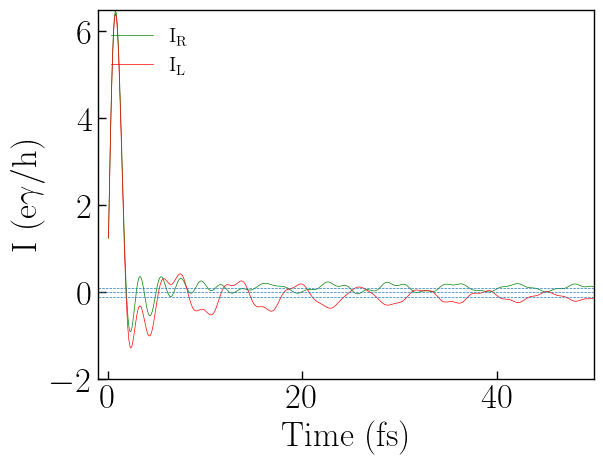

In [25]:
fig,axs = plt.subplots(1,1)
fs=25
#*1000000*1.25/2pi
axs.plot(ts_cc,-cc_αt[1,:]*4pi,color= "green",lw = 0.5,label = raw"$\mathrm{I_R}$")
axs.plot(ts_cc,-cc_αt[2,:]*4pi,color= "red",lw = 0.5,label = raw"$\mathrm{I_L}$")
axs.set_ylabel(L"$\mathrm{I\ (e\gamma/h)}$", fontsize = fs)
axs.set_xlabel(raw"$\mathrm{Time\ (fs)}$",fontsize = fs)
axs.tick_params(axis="both", which="both", labelsize=fs,direction="in", length=6,width=1)
axs.ticklabel_format(axis="y", style="sci", scilimits=(-1,2), useMathText=true)
axs.yaxis.offsetText.set_fontsize(fs)
plt.legend(frameon = false, fontsize = fs-10, loc= (0.01,  0.8))
plt.xlim(-1,50)
plt.axhline(0.1,ls = "--",lw=0.5)
plt.axhline(-0.1,ls = "--",lw=0.5)
plt.axhline(0.0,ls = "--",lw=0.5)
#plt.axhline(0.05,ls = "--",lw=0.5)
plt.ylim(-2,6.5)
#plt.ylim(0.1-1e-1,0.1+1e-1)
plt.show()

### Spin Current 

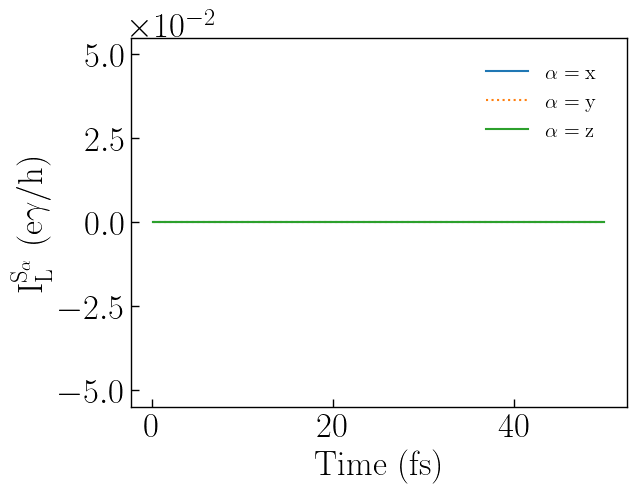

PyObject <matplotlib.legend.Legend object at 0x7f4078228a40>

In [26]:
fig,axs = plt.subplots(1,1)
axs.plot(ts_sc,sc_αxt[1,1,:], label = raw"$\mathrm{\alpha = x}$")
axs.plot(ts_sc,sc_αxt[1,2,:], label = raw"$\mathrm{\alpha = y}$",ls=":")
axs.plot(ts_sc,sc_αxt[1,3,:], label = raw"$\mathrm{\alpha = z}$")

# axs.plot(ts_sc,sc_αxt[2,1,:], label = raw"$\mathrm{\alpha = x}$")
# axs.plot(ts_sc,sc_αxt[2,2,:], label = raw"$\mathrm{\alpha = y}$",ls=":")
# axs.plot(ts_sc,sc_αxt[2,3,:], label = raw"$\mathrm{\alpha = z}$")
axs.set_ylabel(raw"$\mathrm{I^{S_{\alpha}}_L\ (e\gamma/h)}$", fontsize = fs)
axs.set_xlabel(raw"$\mathrm{Time\ (fs)}$",fontsize = fs)
axs.tick_params(axis="both", which="both", labelsize=fs,direction="in", length=6,width=1)
axs.ticklabel_format(axis="y", style="sci", scilimits=(-1,2), useMathText=true)
axs.yaxis.offsetText.set_fontsize(fs)
#plt.xlim(190,200)
plt.legend(frameon = false, fontsize = fs-10, loc= (0.7,  0.7))

### Spin density

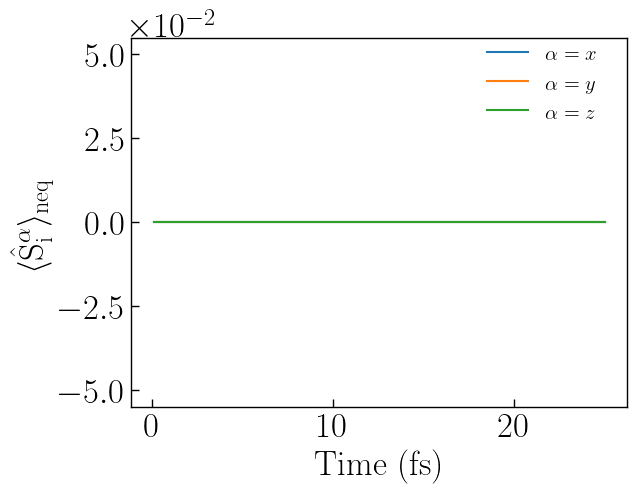

PyObject <matplotlib.legend.Legend object at 0x7f40780c3110>

In [27]:
fig,axs = plt.subplots(1,1)
fs=25
site = 1
mag = sneq_ta1x[:,site,1].^2 +sneq_ta1x[:,site,2].^2 + sneq_ta1x[:,site,3].^2
axs.plot(ts_sn,sneq_ta1x[:,site,1],label = raw"$\alpha=x$")
axs.plot(ts_sn,sneq_ta1x[:,site,2],label = raw"$\alpha=y$")
axs.plot(ts_sn,sneq_ta1x[:,site,3],label = raw"$\alpha=z$")
axs.set_ylabel(raw"$\langle\mathrm{\hat{S}^{\alpha}_{i}}\rangle_{\mathrm{neq}}$", fontsize = fs)
axs.set_xlabel(raw"$\mathrm{Time\ (fs)}$",fontsize = fs)
axs.tick_params(axis="both", which="both", labelsize=fs,direction="in", length=6,width=1)
axs.ticklabel_format(axis="y", style="sci", scilimits=(-1,2), useMathText=true)
axs.yaxis.offsetText.set_fontsize(fs)
#plt.xlim(190,200)
plt.legend(frameon = false, fontsize = fs-10, loc= (0.7,  0.75))

### Local density 

In [1]:
fig,axs =  plt.subplots(1,1)
site = 1
sites = range(1,6)
# for i in site 
#     axs.plot(ts_cd, cden_ta1[:,i]*det,label= "site=$(i)")#,alpha =1-0.2*i ) ### Charge bound current
#     axs.plot(ts_cd, cden_ta1[:,i+1]*det,label= "site=$(i+1)")#
# end
axs.plot(ts_cd/hbar, (cden_ta1[:,1]),label= "site=$(1)")#,alpha =1-0.2*i ) ### Charge bound current

axs.plot(ts_cd/hbar, (cden_ta1[:,4]),label= "site=$(2)")

axs.set_ylabel(raw"$\langle\mathrm{\hat{n}^{\alpha}_i}\rangle$", fontsize = fs)
axs.set_xlabel(raw"$\mathrm{Time\ (fs)}$",fontsize = fs)
axs.tick_params(axis="both", which="both", labelsize=fs,direction="in", length=6,width=1)
axs.ticklabel_format(axis="y", style="sci", scilimits=(-1,2), useMathText=true)
axs.yaxis.offsetText.set_fontsize(fs)
plt.legend(frameon = false, fontsize = fs-10, loc= (0.7,  0.1))
plt.xlim(-1,60)
plt.axhline(0.5,ls = "--",color="gray",lw = 0.5)
#plt.ylim(-1e-2,1e-2)

LoadError: UndefVarError: `plt` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

### Classical magnetization

sys:1: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
sys:1: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown


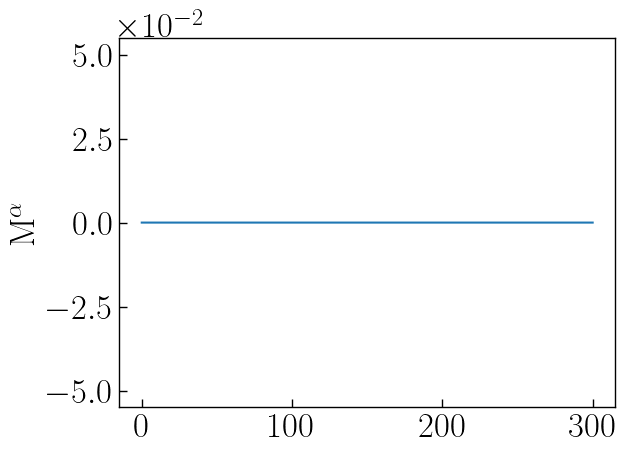

In [1369]:
fig,axs = plt.subplots(1,1)
fs=25
site = 2
axs.plot(ts_cs,cspins_tax[:,site,2])
#axs.plot(ts_cs,cspins_tax[:,site+2,3])
axs.set_ylabel(L"$\mathrm{M^{\alpha}}$", fontsize = fs)
#axs.set_xlabel(raw"$\mathrm{Time\ (fs)}$",fontsize = fs)
#axs.set_ylim([-5e-1,+5e-1])
#axs.set_ylim([-40e-1,40e-1])
axs.tick_params(axis="both", which="both", labelsize=fs,direction="in", length=6,width=1)
axs.ticklabel_format(axis="y", style="sci", scilimits=(-1,2), useMathText=true)
axs.yaxis.offsetText.set_fontsize(fs)
#axs.set_xlim([350,800])
#axs.set_xlim([950,1050])
plt.legend(frameon = false, fontsize = fs-10, loc= (0.01,  0.8))
plt.show()
#axs.set_xlim(1800,2100)

## Save data

In [34]:
using DelimitedFiles
path = "/home/jalil2/Documents/KBA/data"
name = "GKBA"

"GKBA"

In [35]:
#cc_αt[:,:]'

### Charge current 


In [36]:

#ccL_f = open("./data/ccL_GKBA_jl.txt", "w+") 
cc_f = open("$(path)/cc_$(name)_jl.txt", "w+") 
#writedlm(ccL_f, [sol.t*hbar 4pi*Curr_left], ' ' )
writedlm(cc_f, [ts_cc -4*pi*cc_αt'], ' ' )
#writedlm(ccR_f, [ts_cc -4*pi*cc_αt[1,:]], ' ' )
#close(ccL_f)
close(cc_f)

### Local density 

In [39]:
#using DelimitedFiles
#ccL_f = open("./data/ccL_GKBA_jl.txt", "w+") 
cden_f = open("$(path)/cd_$(name)_jl.txt", "w+") 
#writedlm(ccL_f, [sol.t*hbar 4pi*Curr_left], ' ' )
writedlm(cden_f, [ts_cd cden_ta1], ' ' )
#close(ccL_f)
close(cden_f)

In [38]:
#cden_ta1